In [1]:
from sklearn import cluster
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score


import warnings
warnings.filterwarnings('ignore')


- k_means


In [2]:
G = nx.karate_club_graph()

pos = nx.spring_layout(G)

In [3]:


def draw_communities(G, membership, pos):
    """Draws the nodes to a plot with assigned colors for each individual cluster
    Parameters
    ----------
    G : networkx graph
    membership : list
        A list where the position is the student and the value at the position is the student club membership.
        E.g. `print(membership[8]) --> 1` means that student #8 is a member of club 1.
    pos : positioning as a networkx spring layout
        E.g. nx.spring_layout(G)
    """ 
    fig, ax = plt.subplots(figsize=(7,6))
    
    # Convert membership list to a dict where key=club, value=list of students in club
    club_dict = defaultdict(list)
    for student, club in enumerate(membership):
        club_dict[club].append(student)
    
    # Normalize number of clubs for choosing a color
    norm = colors.Normalize(vmin=0, vmax=len(club_dict.keys()))
    
    for club, members in club_dict.items():
        nx.draw_networkx_nodes(G, pos,
                               nodelist=members,
                               node_color=cm.jet(norm(club)),
                               node_size=500,
                               alpha=0.8,
                               ax=ax)

    # Draw edges (social connections) and show final plot
    labels = {i: i for i in range(len(membership))}
    nx.draw_networkx_labels(G, pos, labels, font_size=15, font_color='black', ax=ax)
    #plt.title("Zachary's Karate Club")
    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)
   

In [4]:
def graph_to_edge_matrix(G):
    """Convert a networkx graph into an edge matrix.
    See https://www.wikiwand.com/en/Incidence_matrix for a good explanation on edge matrices
   
    Parameters
    ----------
    G : networkx graph
    """
    # Initialize edge matrix with zeros
    edge_mat = np.zeros((len(G), len(G)), dtype=int)

    # Loop to set 0 or 1 (diagonal elements are set to 1)
    for node in G:
        for neighbor in G.neighbors(node):
            edge_mat[node][neighbor] = 1
        edge_mat[node][node] = 1

    return edge_mat

In [5]:
edge_mat = graph_to_edge_matrix(G)
edge_mat

array([[1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

#### K-means

In [6]:
k_clusters = 4
results = []
algorithms = {}

algorithms['kmeans'] = cluster.KMeans(n_clusters=k_clusters, n_init=200)

#### Agglomerative Clustering

In [7]:
algorithms['agglom'] = cluster.AgglomerativeClustering(n_clusters=6, linkage="ward")

#### Spectral Clustering

In [8]:
algorithms['spectral'] = cluster.SpectralClustering(n_clusters=3, affinity="precomputed", n_init=200)

#### Affinity Propagation

In [9]:
algorithms['affinity'] = cluster.AffinityPropagation(damping=0.6)

# Fit all models
for model in algorithms.values():
    model.fit(edge_mat)
    results.append(list(model.labels_))

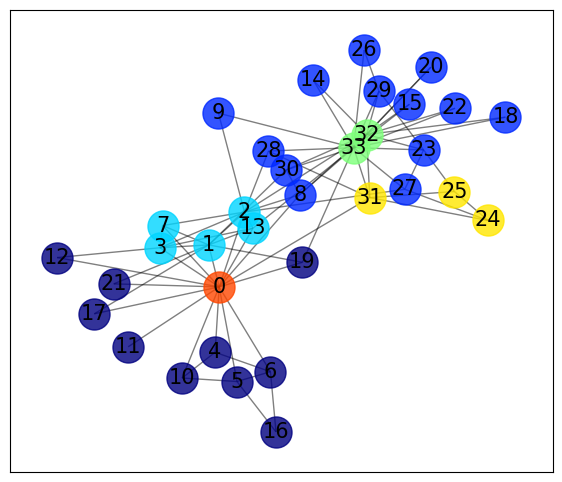

In [11]:
# algorithms['kmeans'].labels_ , algorithms['agglom'].labels_ , algorithms['spectral'].labels_ , algorithms['affinity'].labels_

draw_communities(G, algorithms['agglom'].labels_, pos)

In [180]:
pd.DataFrame(algorithms['affinity'].labels_).value_counts().count()

9

## Modularity

In [12]:

from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, AffinityPropagation
from networkx.algorithms.community import modularity

#### K-means

In [13]:
modularity_list = []

# Apply K-means
num_clusters = 4  # you can adjust the number of clusters based on your needs
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_assignments = kmeans.fit_predict(edge_mat)

# Determine the unique cluster labels
unique_clusters = set(cluster_assignments)

# Create a list of sets representing the partition
partition = [set() for _ in range(num_clusters)]

for node, cluster in zip(G.nodes, cluster_assignments):
    partition[cluster].add(node)

# Calculate modularity
modularity_score = modularity(G, partition)
modularity_list.append(modularity_score)
print("Modularity:", modularity_score)


Modularity: 0.19761623657727556


#### Agglomerative Clustering

In [14]:

num_clusters = 6  # you can adjust the number of clusters based on your needs
agglom = AgglomerativeClustering(n_clusters=k_clusters, linkage="ward")
cluster_assignments = agglom.fit_predict(edge_mat)


# Determine the unique cluster labels
unique_clusters = set(cluster_assignments)

# Create a list of sets representing the partition
partition = [set() for _ in range(num_clusters)]

for node, cluster in zip(G.nodes, cluster_assignments):
    partition[cluster].add(node)

# Calculate modularity
modularity_score = modularity(G, partition)
modularity_list.append(modularity_score)
print("Modularity:", modularity_score)


Modularity: 0.19761623657727556


#### Spectral Clustering

In [15]:
num_clusters = 3  # you can adjust the number of clusters based on your needs
spectral = SpectralClustering(n_clusters=num_clusters, affinity="precomputed", n_init=200)
cluster_assignments = spectral.fit_predict(edge_mat)

# Determine the unique cluster labels
unique_clusters = set(cluster_assignments)

# Create a list of sets representing the partition
partition = [set() for _ in range(num_clusters)]

for node, cluster in zip(G.nodes, cluster_assignments):
    partition[cluster].add(node)

# Calculate modularity
modularity_score = modularity(G, partition)
modularity_list.append(modularity_score)
print("Modularity:", modularity_score)


Modularity: 0.4345214669889994


#### Affinity Propagation

In [16]:
# Apply Affinity Propagation
affinity = AffinityPropagation(damping=0.6)
cluster_assignments = affinity.fit_predict(edge_mat)

# Create a list of sets representing the partition
partition = [set() for _ in range(len(set(cluster_assignments)))]
for node, cluster in zip(G.nodes, cluster_assignments):
    partition[cluster].add(node)

# Calculate modularity
modularity_score = modularity(G, partition)
modularity_list.append(modularity_score)
print("Modularity:", modularity_score)


Modularity: 0.20288225483030678


In [17]:
modularity_list

[0.19761623657727556,
 0.19761623657727556,
 0.4345214669889994,
 0.20288225483030678]